In [1]:
import pandas as pd
import pickle
from nltk import FreqDist
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
with open("../data/concs_labeled.pickle", "rb") as f:
    concs_labeled = pickle.load(f)

In [3]:
concs_labeled[:10]

[(['legislative',
   'election',
   'substantial',
   'body',
   'research',
   'document',
   'connection',
   'political',
   'discontent',
   'populist',
   'voting',
   '.',
   '2002',
   'Norris_2005',
   'Schumacher',
   'Rooduijn',
   'expectation',
   'group',
   'relatively',
   'engaged'],
  'nationalist',
  '2020'),
 (['corrosive',
   'tactic',
   'exaggerated',
   'shock',
   'fascism',
   'rise',
   'the_interwar_year',
   'prominent',
   'recent',
   'case',
   'populist',
   'move',
   'burgeon',
   'literature',
   'threat',
   'U.S.',
   'democracy',
   'overestimate',
   'openness',
   'institution'],
  'authoritatian',
  '2020'),
 (['recent',
   'upsurge',
   'populism',
   'fact',
   'weak',
   'institutional',
   'setting',
   'contemporary',
   'Latin_America',
   'Eastern_Europe',
   'populist',
   'leader',
   'fail',
   'machination',
   'observer',
   'overly',
   'impressed',
   'scare',
   'relatively',
   'case'],
  'authoritatian',
  '2020'),
 (['effort',


In [78]:
y = [el[1] for el in concs_labeled]

In [5]:
labels_counts = FreqDist(y).most_common()
labels_counts

[('right-wing', 2660),
 ('nationalist', 1594),
 ('left-wing', 731),
 ('authoritatian', 637),
 ('radical', 515),
 ('exclusive', 366),
 ('moderate', 235),
 ('neoliberal', 232),
 ('inclusive', 216),
 ('nativist', 194)]

In [141]:
classes = [t[0] for t in labels_counts]
print(classes)

['right-wing', 'nationalist', 'left-wing', 'authoritatian', 'radical', 'exclusive', 'moderate', 'neoliberal', 'inclusive', 'nativist']


# Features preprocessing

In [ ]:
concs = [el[0] for el in concs_labeled]

In [6]:
vocab_counts = FreqDist([w for conc in concs for w in conc]).most_common()
vocab_counts[:50]

[('populist', 7105),
 ('populism', 4933),
 ('party', 3265),
 ('political', 1495),
 ('people', 1005),
 ('democracy', 726),
 ('politic', 647),
 ('support', 616),
 ('leader', 603),
 ('attitude', 581),
 ('case', 574),
 ('discourse', 531),
 ('effect', 502),
 ('economic', 474),
 ('elite', 462),
 ('country', 441),
 ('ideology', 441),
 ('study', 416),
 ('democratic', 413),
 ('government', 413),
 ('different', 402),
 ('movement', 400),
 ('policy', 383),
 ('power', 380),
 ('issue', 370),
 ('two', 368),
 ('voter', 365),
 ('argue', 360),
 ('new', 359),
 ('analysis', 331),
 ('form', 324),
 ('level', 322),
 ('social', 317),
 ('focus', 317),
 ('election', 313),
 ('rise', 313),
 ('liberal', 302),
 ('electoral', 300),
 ('article', 300),
 ('vote', 295),
 ('state', 293),
 ('rhetoric', 290),
 ('appeal', 282),
 ('european', 281),
 ('position', 279),
 ('Europe', 277),
 ('2017', 276),
 ('one', 273),
 ('mainstream', 267),
 ('result', 260)]

In [7]:
len(vocab_counts)

13470

In [64]:
N = 10000
vocab = [tup[0] for tup in vocab_counts][:N]

In [65]:
vectorizer = TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab, lowercase=False)
X = vectorizer.fit_transform([" ".join(conc) for conc in concs]).A

In [66]:
X.shape

(7380, 10000)

In [67]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.050521,0.000000,0.000000,0.099734,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.049467,0.000000,0.000000,0.000000,0.0,0.127037,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.049939,0.063344,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.134533,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.047340,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.049899,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.130818,0.134425,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,0.117001,0.074203,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.161536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7376,0.054440,0.069054,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.150325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7377,0.054352,0.000000,0.085035,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7378,0.000000,0.074470,0.091855,0.115902,0.0,0.000000,0.150702,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
len(y)

7380

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Model development

## Logistic regression

In [74]:
LR = LogisticRegression(penalty="l2", C=1000, n_jobs=-1)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6537940379403794

In [83]:
y_predicted = LR.predict(X_test)
y_predicted[:10]

array(['radical', 'nationalist', 'left-wing', 'moderate', 'nationalist',
       'right-wing', 'nationalist', 'nationalist', 'nationalist',
       'nationalist'], dtype='<U13')

In [85]:
y_test[:10]

['radical',
 'nationalist',
 'left-wing',
 'moderate',
 'nationalist',
 'right-wing',
 'left-wing',
 'nationalist',
 'nationalist',
 'authoritatian']

In [86]:
f1_score(y_predicted, y_test, average="weighted")

0.6608948277473405

## Multinomial Naive Bayes

In [75]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB.score(X_test, y_test)

0.44037940379403795

## Random Forests

In [87]:
RF = RandomForestClassifier(n_jobs=-1, n_estimators=100)
RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.5853658536585366

## Extremely Randomized Trees

In [88]:
# apply carefully! takes time
ET = ExtraTreesClassifier(n_jobs=-1, n_estimators=100)
ET.fit(X_train, y_train)
ET.score(X_test, y_test)

0.6307588075880759

# Model evaluation

In [90]:
classifier = LR

In [93]:
classifier.score(X_test, y_test)

0.6537940379403794

In [94]:
y_predicted = classifier.predict(X_test)
f1_score(y_predicted, y_test, average="weighted")

0.6608948277473405

In [125]:
test_classes_reality = dict(FreqDist(y_test).most_common())
test_classes_reality

{'right-wing': 536,
 'nationalist': 306,
 'left-wing': 157,
 'radical': 126,
 'authoritatian': 112,
 'exclusive': 71,
 'inclusive': 51,
 'neoliberal': 46,
 'moderate': 40,
 'nativist': 31}

In [132]:
labels_reality = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_reality.items()]
labels_reality

['right-wing (N=536)',
 'nationalist (N=306)',
 'left-wing (N=157)',
 'radical (N=126)',
 'authoritatian (N=112)',
 'exclusive (N=71)',
 'inclusive (N=51)',
 'neoliberal (N=46)',
 'moderate (N=40)',
 'nativist (N=31)']

In [126]:
test_classes_prediction = dict(FreqDist(y_predicted).most_common())
test_classes_prediction

{'right-wing': 627,
 'nationalist': 338,
 'left-wing': 155,
 'authoritatian': 94,
 'radical': 93,
 'exclusive': 55,
 'moderate': 34,
 'neoliberal': 29,
 'inclusive': 27,
 'nativist': 24}

In [133]:
labels_prediction = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_prediction.items()]
labels_prediction

['right-wing (N=627)',
 'nationalist (N=338)',
 'left-wing (N=155)',
 'authoritatian (N=94)',
 'radical (N=93)',
 'exclusive (N=55)',
 'moderate (N=34)',
 'neoliberal (N=29)',
 'inclusive (N=27)',
 'nativist (N=24)']

In [134]:
pd.DataFrame([test_classes_reality, test_classes_prediction], index=["reality", "prediction"]).T

,reality,prediction
right-wing,536,627
nationalist,306,338
left-wing,157,155
radical,126,93
authoritatian,112,94
exclusive,71,55
inclusive,51,27
neoliberal,46,29
moderate,40,34
nativist,31,24


In [135]:
matrix = confusion_matrix(y_test, y_predicted, labels=labels) #, normalize="true")
dataframe = pd.DataFrame(matrix, index=labels_reality, columns=labels_prediction)
dataframe

,right-wing (N=627),nationalist (N=338),left-wing (N=155),authoritatian (N=94),radical (N=93),exclusive (N=55),moderate (N=34),neoliberal (N=29),inclusive (N=27),nativist (N=24)
right-wing (N=536),435,42,25,6,12,6,5,1,1,3
nationalist (N=306),56,213,19,8,5,3,0,0,2,0
left-wing (N=157),41,23,77,3,7,3,1,1,0,1
radical (N=126),20,13,3,68,5,1,0,0,2,0
authoritatian (N=112),32,13,18,6,49,4,1,1,1,1
exclusive (N=71),11,12,4,1,4,36,0,0,2,1
inclusive (N=51),7,3,1,0,3,0,25,0,1,0
neoliberal (N=46),6,7,2,1,3,1,0,26,0,0
moderate (N=40),12,8,6,1,3,1,2,0,18,0
nativist (N=31),7,4,0,0,2,0,0,0,0,18


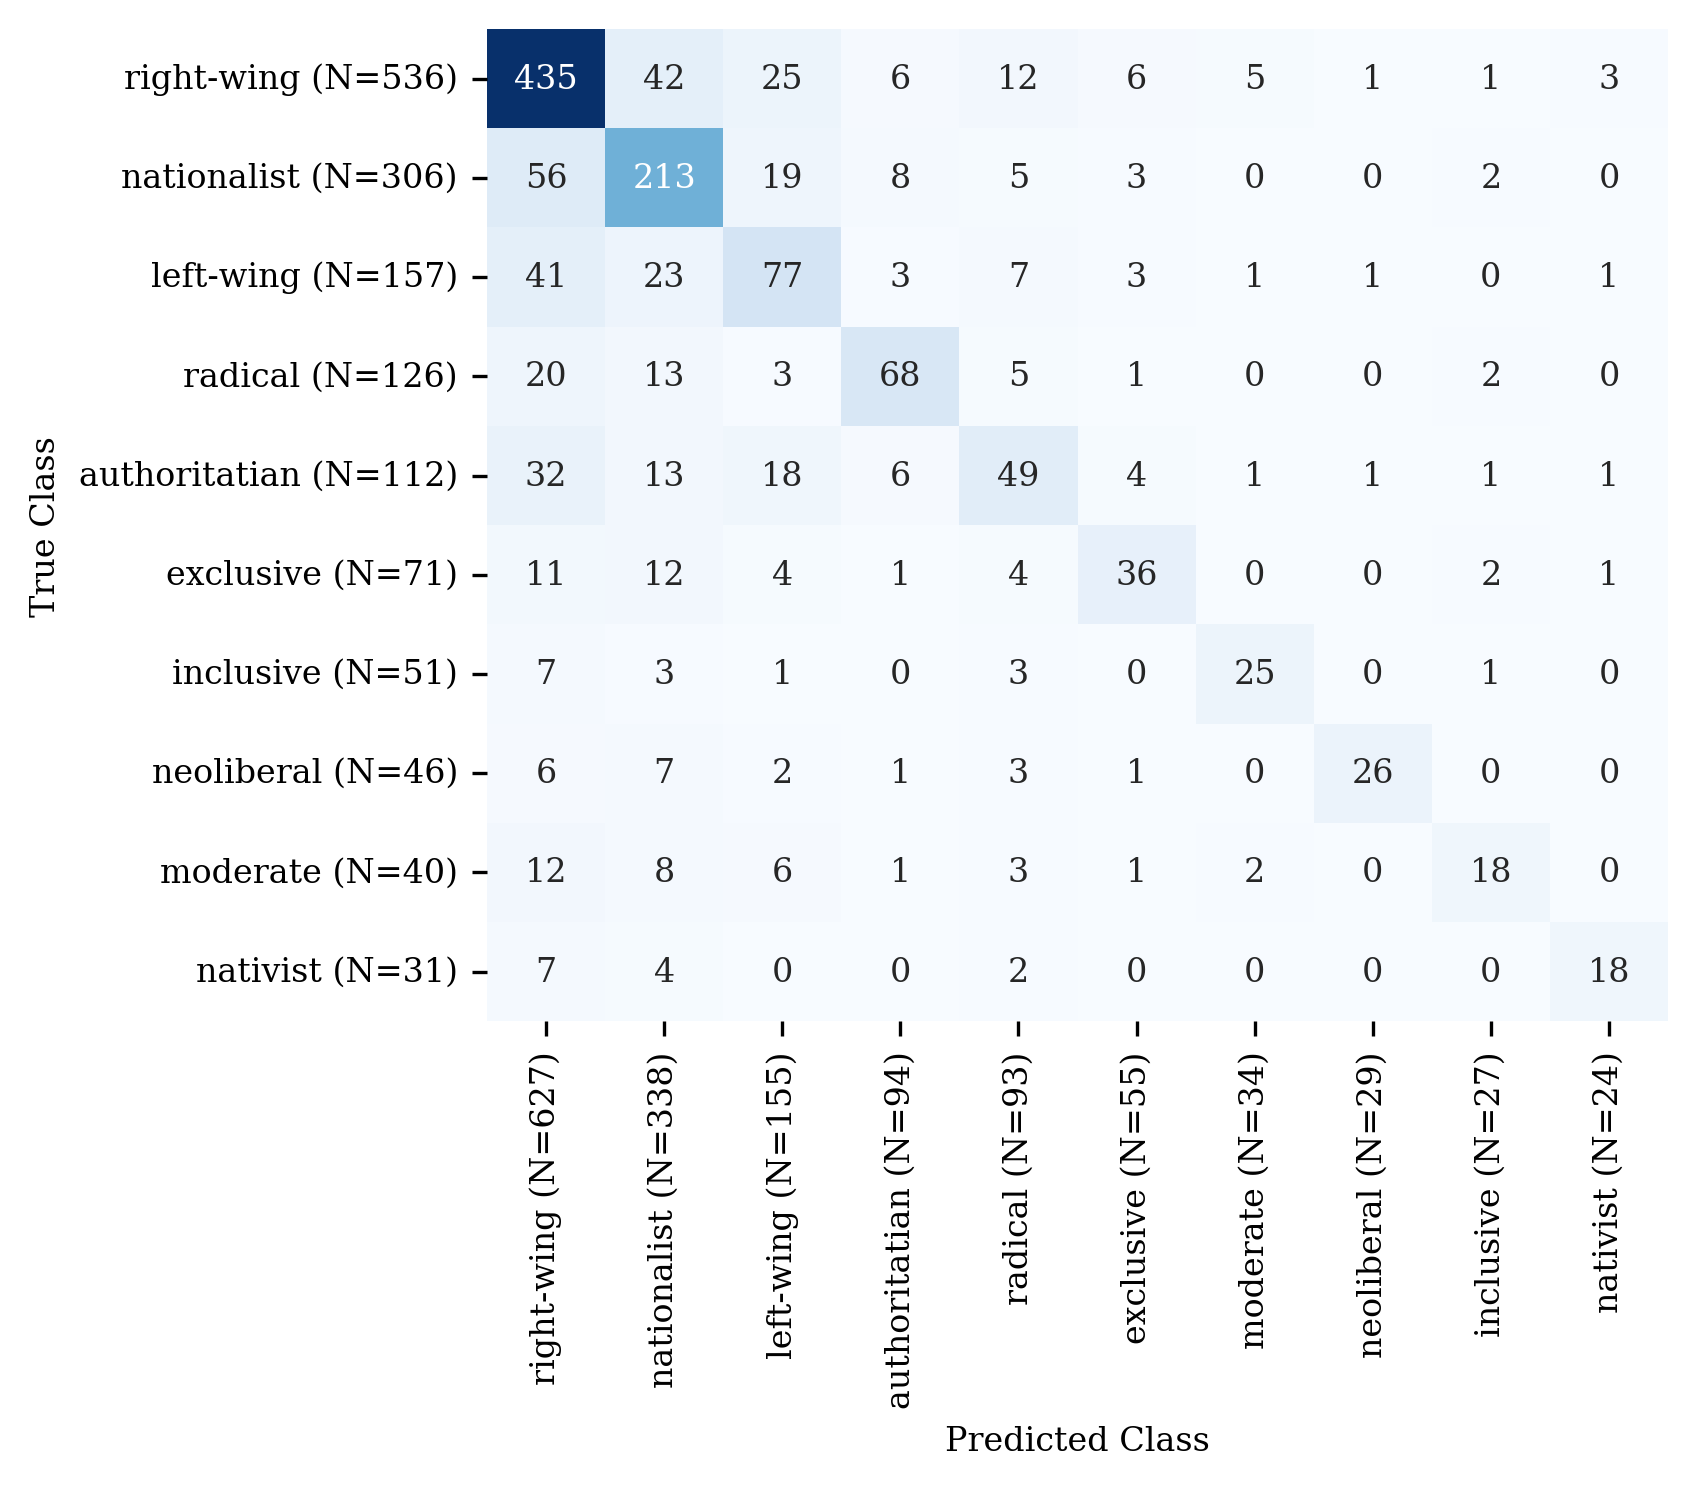

In [140]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='d', ax=ax)

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

In [260]:
dummy = DummyClassifier(strategy='stratified', random_state=1)


In [261]:
dummy.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [5904, 4723]

# NN based classification

## Simply neural network

In [153]:
# requires to be connected to a properly configured python environment with tensorflow etc.
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import models
from keras import layers

from keras.layers import Embedding


In [144]:
classes_inxs = dict(zip(classes, range(len(classes))))

{'right-wing': 0,
 'nationalist': 1,
 'left-wing': 2,
 'authoritatian': 3,
 'radical': 4,
 'exclusive': 5,
 'moderate': 6,
 'neoliberal': 7,
 'inclusive': 8,
 'nativist': 9}

In [146]:
def to_one_hot(y, classes):
    classes_inxs_dict = dict(zip(classes, range(len(classes))))
    results = np.zeros((len(y), len(classes)))
    for i, label in enumerate(y):
        results[i, classes_inxs_dict[label]] = 1.
    return results, classes_inxs_dict

one_hot_labels, classes_inxs_dict = to_one_hot(y, classes)

In [165]:
inxs_classes_dict = dict([(t[1], t[0]) for t in classes_inxs_dict.items()])
inxs_classes_dict

{0: 'right-wing',
 1: 'nationalist',
 2: 'left-wing',
 3: 'authoritatian',
 4: 'radical',
 5: 'exclusive',
 6: 'moderate',
 7: 'neoliberal',
 8: 'inclusive',
 9: 'nativist'}

In [147]:
one_hot_labels[:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [175]:
# TRAIN vs TEST

x_train_full, x_test, y_train_full, y_test_one_hot = train_test_split(X, one_hot_labels, test_size=0.2, random_state=1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2)

In [155]:
# since our classes are highly unbalanced w1 weighted is perhaps the best metric for model performance
def f1_weighted(y_true, y_pred):
    y_true = np.ndarray.argmax(y_true.numpy(), axis=1)
    y_pred = np.ndarray.argmax(y_pred.numpy(), axis=1)
    return f1_score(y_true, y_pred, average="weighted")

In [192]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(len(x_train[0]),)))
model.add(layers.Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_weighted])

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - ETA: 0s - loss: 1.9676 - f1_weighted: 0.2075

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 4s 98ms/step - loss: 1.9676 - f1_weighted: 0.2075 - val_loss: 1.7352 - val_f1_weighted: 0.3005
Epoch 2/10
37/37 [==============================] - 4s 98ms/step - loss: 1.4153 - f1_weighted: 0.4407 - val_loss: 1.4593 - val_f1_weighted: 0.4464
Epoch 3/10
37/37 [==============================] - 3s 92ms/step - loss: 0.8778 - f1_weighted: 0.7001 - val_loss: 1.2551 - val_f1_weighted: 0.5622
Epoch 4/10
37/37 [==============================] - 3s 93ms/step - loss: 0.4338 - f1_weighted: 0.9063 - val_loss: 1.1764 - val_f1_weighted: 0.5996
Epoch 5/10
37/37 [==============================] - 3s 94ms/step - loss: 0.1947 - f1_weighted: 0.9790 - val_loss: 1.1742 - val_f1_weighted: 0.6275
Epoch 6/10
37/37 [==============================] - 3s 88ms/step - loss: 0.0935 - f1_weighted: 0.9974 - val_loss: 1.2127 - val_f1_weighted: 0.6279
Epoch 7/10
37/37 [==============================] - 3s 93ms/step - loss: 0.0528 - f1_weighted: 0.9996 - val_loss: 1.2451 - val_f1

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 62ms/step - loss: 1.2960 - f1_weighted: 0.6288


In [194]:
results = model.evaluate(x_test, y_test_one_hot)
results

 2/47 [>.............................] - ETA: 2s - loss: 0.9033 - f1_weighted: 0.7048

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 62ms/step - loss: 1.2960 - f1_weighted: 0.6288


[1.2959922552108765, 0.6288107633590698]

In [197]:
y_predicted_one_hot = model.predict(x_test)
y_predicted = [inxs_classes_dict[i] for i in np.argmax(y_predicted_one_hot, axis=1)]

47/47 [==============================] - 0s 5ms/step


In [198]:
f1_score(y_predicted, y_test, average="weighted")

0.6548739390014741

In [246]:
inxs_classes_dict

{0: 'right-wing',
 1: 'nationalist',
 2: 'left-wing',
 3: 'authoritatian',
 4: 'radical',
 5: 'exclusive',
 6: 'moderate',
 7: 'neoliberal',
 8: 'inclusive',
 9: 'nativist'}

In [249]:
pd.DataFrame(y_predicted_one_hot[:10].round(2), columns=labels)

,right-wing,nationalist,left-wing,authoritatian,radical,exclusive,moderate,neoliberal,inclusive,nativist
0,0.01,0.01,0.00,0.00,0.97,0.01,0.00,0.00,0.00,0.00
1,0.01,0.80,0.02,0.01,0.11,0.00,0.00,0.04,0.00,0.00
2,0.26,0.02,0.71,0.01,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.02,0.00,0.02,0.00,0.96,0.00,0.00,0.00
4,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.98,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
6,0.06,0.91,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00
7,0.04,0.84,0.02,0.02,0.02,0.00,0.04,0.00,0.01,0.01
8,0.01,0.94,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.00
9,0.00,0.95,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00


In [255]:
len(np.max(y_predicted_one_hot, axis=1))

1476

In [259]:
sum(np.max(y_predicted_one_hot, axis=1) > 0.75)

917

# Neural networks with embeddings

In [200]:
import gensim.downloader

In [201]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [220]:
keyed_vectors = gensim.downloader.load("glove-twitter-100") #glove-wiki-gigaword-100")

[===-----------------------------------------------] 6.1% 23.4/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.3% 74.7/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.5% 125.6/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
keyed_vectors.most_similar("extremism")

[('islamism', 0.7601100206375122),
 ('extremists', 0.7432481646537781),
 ('terrorism', 0.7383471131324768),
 ('fundamentalism', 0.7325897812843323),
 ('sectarianism', 0.7256608605384827),
 ('bigotry', 0.7209097146987915),
 ('islamophobia', 0.7202947735786438),
 ('fascism', 0.7078671455383301),
 ('persecution', 0.7032996416091919),
 ('extremist', 0.7023182511329651)]

In [224]:
keyed_vectors["left-wing"]

array([ 0.1156   ,  0.11654  , -0.15217  ,  0.24149  ,  0.023362 ,
        0.32094  , -0.57008  , -0.32707  ,  0.40248  , -1.1674   ,
        0.33613  , -0.68625  , -0.0013389,  0.053146 ,  0.22417  ,
       -0.64114  , -0.089681 , -0.56791  ,  0.1966   ,  0.29333  ,
        0.27711  , -0.010586 , -0.13308  ,  0.21209  , -0.58683  ,
        1.2109   ,  0.11058  , -0.067238 ,  0.013592 , -0.36465  ,
        1.3305   ,  0.66026  ,  0.39651  ,  0.27792  , -0.67021  ,
       -0.39476  , -0.10197  ,  0.81333  ,  0.17486  , -0.90206  ,
        0.71589  , -0.35144  ,  0.52847  , -0.096732 , -0.050329 ,
        0.70825  , -0.53625  ,  0.19923  , -0.1669   ,  0.60331  ,
        0.096831 ,  0.56722  ,  0.017154 , -0.26199  , -0.67098  ,
        0.76391  , -0.51465  , -0.4536   , -0.64316  ,  0.10226  ,
       -0.29546  ,  0.37123  , -0.91416  , -0.14668  ,  0.042021 ,
        0.62346  ,  0.3533   ,  0.31953  , -0.29972  ,  0.44156  ,
       -0.27269  , -0.55184  , -0.57577  ,  0.10036  , -0.2041

In [227]:
cosine_similarity([keyed_vectors["extremism"],  keyed_vectors["populism"]])

array([[1.0000004, 0.5859166],
       [0.5859166, 1.       ]], dtype=float32)

In [235]:
keyed_vectors.vectors.shape

(1193514, 100)

In [238]:
len(vocab)

10000

In [240]:
vectors_matrix = np.zeros((len(vocab), keyed_vectors.vectors.shape
         [1]))
vectors_matrix[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [241]:
vectors_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [242]:
for i, word in enumerate(vocab[:10]):
    vectors_matrix[i] = keyed_vectors[word]

In [243]:
vectors_matrix[:10]

array([[ 2.57200003e-01, -2.07859993e-01,  1.62990004e-01,
         4.64500010e-01,  5.03369987e-01,  7.05049992e-01,
        -3.90740007e-01, -5.37570000e-01, -2.28369996e-01,
        -8.77009988e-01, -8.93440023e-02, -7.44260013e-01,
         2.66890004e-02,  1.50999993e-01,  1.18330002e-01,
         2.60520000e-02,  4.76510003e-02,  1.09779999e-01,
         1.91780001e-01,  3.07539999e-01, -1.67539999e-01,
         2.88049996e-01, -1.61489993e-01, -3.74320000e-01,
        -4.05840009e-01,  1.34800005e+00,  5.36539972e-01,
        -9.06189978e-02, -2.14629993e-01, -2.44289994e-01,
         9.72079992e-01,  4.03800011e-01, -4.61019995e-03,
         9.50639993e-02, -3.31090003e-01, -2.15470001e-01,
        -1.38060004e-01,  8.01389992e-01,  1.15060002e-01,
        -7.36930013e-01,  3.29990000e-01,  5.20519987e-02,
         1.17289998e-01,  5.26699983e-02,  3.93020004e-01,
         1.79179996e-01, -5.64589977e-01,  1.48800001e-01,
        -2.48370007e-01,  4.31259990e-01,  5.10280013e-0

In [149]:
# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(10000, 256)